* In this section, we take a deep dive into details of **backward propagation** also known as **backpropagation**.

## 1.1 Forward Propagation.

* **forward propagation** is the calculation and storage of intermediate variables for a neural network in order from the input layer to the output layer.

* Let's assume that the input example is **x** and that our hidden layers does not include a bias term.
* Here the intermediate variable is:
  $z = W^{(1)}x$.
* Here  $ W^{(1)}$ is the weight parameter of the hidden layer.

In [113]:
import torch

In [114]:
y = torch.randn(4,4)

In [115]:
x = torch.rand(3,4,requires_grad=True)
w_1 = torch.rand(4,3,requires_grad=True)
z = torch.matmul(w_1,x)
z

tensor([[0.4196, 1.0340, 0.7025, 0.7207],
        [0.6880, 1.4145, 0.8733, 1.0308],
        [0.3399, 1.3209, 1.0559, 0.8510],
        [0.7494, 1.3893, 0.7735, 1.0138]], grad_fn=<MmBackward0>)

* After running intermiadiate variable $z$ through activation function $Φ$ we obtain our hidden activation vector of length $h$:

$h = Φ (z)$.

In [116]:
def relu(X):
  return torch.max(torch.tensor(0.0),X)

In [117]:
h = relu(z)
h

tensor([[0.4196, 1.0340, 0.7025, 0.7207],
        [0.6880, 1.4145, 0.8733, 1.0308],
        [0.3399, 1.3209, 1.0559, 0.8510],
        [0.7494, 1.3893, 0.7735, 1.0138]], grad_fn=<MaximumBackward0>)

* The hidden layer output $h$ is also an intermediate variable.
* Assumng that the parameters of the output layer posses only weight of $ W^{(2)}$, we can obtain an output layer variable with a vector of length q:
   
   $
   o =  W^{(2)} h
   $

In [118]:
w_2 = torch.rand(4,4,requires_grad=True)
o = torch.matmul(w_2,h)
o

tensor([[1.4176, 3.3797, 2.2487, 2.3617],
        [0.7570, 1.7180, 1.1118, 1.2115],
        [1.0001, 2.5503, 1.7463, 1.7506],
        [0.7228, 1.9312, 1.3586, 1.3217]], grad_fn=<MmBackward0>)

* Assuming the loss function $l$ and the example label is $y$, we can can calculate the loss term for a single data example:
  $L = l(o,y)$

In [131]:
def loss(y_true,y_hat):
  ##ensuring values of y_hat are positive for log
  #y_hat_clipped = torch.clamp(y_hat,min=1e-8) #avoids log(0)
  return 0.5*torch.mean((y_hat-y_true)**2)

In [120]:
L=loss(y,o)
L

tensor(1.6228, grad_fn=<MulBackward0>)

* Given the hyperparameter $λ$, the regularization term is:
  
  $s = \frac{\lambda}{2} \left( \|W^{(1)}\|_F^2 + \|W^{(2)}\|_F^2 \right)$

* where the Frobenius norm of a matrix is simply the $l_2$.
* Finally, the model's regularized loss on a given data example is:
  $J = L + s$
* We refer to $J$ as the $objective function$.

In [121]:
##regularization term
lambda_ = 0.1
s = lambda_*0.5*(torch.norm(w_1,p='fro') + torch.norm(w_2,p='fro'))
s

tensor(0.2170, grad_fn=<MulBackward0>)

In [122]:
##objective function
J =L + s
J

tensor(1.8398, grad_fn=<AddBackward0>)

## 2 Computational Graph of Forward Propagation


# Task
Install `torchviz`, re-initialize the tensors `x`, `w_1`, and `w_2` with `requires_grad=True`, and then re-run the forward propagation to ensure the computation graph is traceable. Finally, use `torchviz.make_dot` to plot the computational graph of the objective function `J`.

## Install torchviz

### Subtask:
Install the torchviz library for visualizing PyTorch computation graphs.


**Reasoning**:
To install the `torchviz` library as per the instructions, I will use `!pip install torchviz` in a code cell.



In [123]:
#get_ipython().system('pip install torchviz')

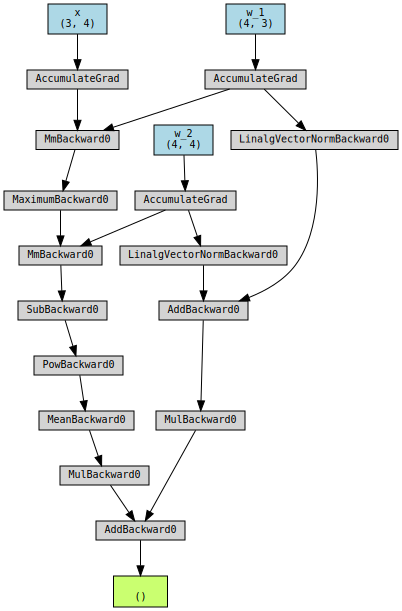

In [124]:
from torchviz import make_dot

# Plot the computational graph of J
graph = make_dot(J, params={'x': x, 'w_1': w_1, 'w_2': w_2,})
graph

## 3 BackPropagation

* Backprogation referes to the method of calculating the gradients of neural networks parameters.
* This method transverses the network transverses the network in reverse order, from output to the input layer, according the **chain rule** from calculus.
* The algorithm stores any intermediate variables required while calculating the gradient with respect to some parameters.
* Assume that we have functions $Y=f(x)$ and $Z=g(x)$, in which the input and output X,Y,Z are tensors of random shapes.
* By using chain rule,we can compute the derivative of $Z$ with respect to $X$ via:
  $\frac{\partial Z}{\partial X} = \frac{\partial Z}{\partial Y} \frac{\partial Y}{\partial X}$

* Here we use the prod operator to multiply its arguments after necessary operations.
* Recall that the parameters of the simple forward pass we previously attempted,its parameters are $W^{(1)}$ and $W^{(2)}$.
* The objective of backpropagation is to calculate the gradients $\frac{\partial J}{\partial W^{(1)}} \quad \text{and} \quad \frac{\partial J}{\partial W^{(2)}}$.
* To accomplish this, we apply chain rule and calculate,in turn the gradients of each intermediate variable and parameter.
* First we calculate the gradient of the objective function $J=L+s$ with respect to the loss term $L$ and the regularization term $S$:
  $\frac{\partial J}{\partial L} = 1 \quad \text{and} \quad \frac{\partial J}{\partial s} = 1$
  


In [125]:
dj_dl =1
dj_ds = 1


* Next we compute the gradient of the objective function with respect to  variable of the output layer $o$ according to chain rule:
  $\frac{\partial J}{\partial o} = \frac{\partial J}{\partial L} \frac{\partial L}{\partial o} = \frac{\partial L}{\partial o} \in \mathbb{R}^q$

In [126]:
N = o.numel()

In [127]:
dl_do = ((o-y)*2)/N
dl_do

tensor([[-0.2308,  0.4037,  0.2244,  0.1764],
        [ 0.1148,  0.2971,  0.2370, -0.0182],
        [ 0.0774,  0.1832,  0.1737,  0.2016],
        [ 0.1187,  0.2212,  0.3522,  0.2414]], grad_fn=<DivBackward0>)

In [128]:
dj_do = dj_dl*dl_do
dj_do

tensor([[-0.2308,  0.4037,  0.2244,  0.1764],
        [ 0.1148,  0.2971,  0.2370, -0.0182],
        [ 0.0774,  0.1832,  0.1737,  0.2016],
        [ 0.1187,  0.2212,  0.3522,  0.2414]], grad_fn=<MulBackward0>)

* Next we calculate the gradients of the regularization term with respect to both parameters:  
  $\frac{\partial s}{\partial W^{(1)}} = \lambda W^{(1)} \quad \text{and} \quad \frac{\partial s}{\partial W^{(2)}} = \lambda W^{(2)}$

In [129]:
ds_dw1 = lambda_*w_1
ds_dw2 = lambda_*w_2
ds_dw1,ds_dw2

(tensor([[0.0398, 0.0382, 0.0593],
         [0.0251, 0.0647, 0.0997],
         [0.0990, 0.0260, 0.0480],
         [0.0148, 0.0765, 0.0951]], grad_fn=<MulBackward0>),
 tensor([[0.0530, 0.0658, 0.0759, 0.0646],
         [0.0513, 0.0243, 0.0217, 0.0402],
         [0.0007, 0.0153, 0.0975, 0.0748],
         [0.0150, 0.0368, 0.0726, 0.0213]], grad_fn=<MulBackward0>))

* Now we are able to calculate the gradient $\frac{\partial J}{\partial W^{(2)}} $ of the model parameters closest to the output layer. Using chain rule yields:
  $\frac{\partial J}{\partial W^{(2)}} = \frac{\partial J}{\partial o} \frac{\partial o}{\partial W^{(2)}} + \frac{\partial J}{\partial s} \frac{\partial s}{\partial W^{(2)}} = \frac{\partial L}{\partial o} h^\top + \lambda W^{(2)}$

In [130]:
dj_dw2 = dj_do*h.T + lambda_*w_2
dj_dw2

tensor([[-0.0439,  0.3436,  0.1522,  0.1968],
        [ 0.1699,  0.4446,  0.3346,  0.0149],
        [ 0.0551,  0.1753,  0.2809,  0.2307],
        [ 0.1005,  0.2648,  0.3724,  0.2661]], grad_fn=<AddBackward0>)

* To obtain the gradients with respect to $W^{(1)}$ we need to continue backpropagation along the output layer to hidden layer.
* The gradient with respect to hidden layer output $\frac{\partial J}{\partial h} \in \mathbb{R}^h$ is given by.
  $\frac{\partial J}{\partial h} = \frac{\partial J}{\partial o} \frac{\partial o}{\partial h} = (W^{(2)})^\top \frac{\partial J}{\partial o}$